# Sentiment Analysis 

The identification of sentiment in text is an important field of study, it usually involves detecting whether a piece of text expresses a POSITIVE, a NEGATIVE, or a NEUTRAL sentiment; the sentiment can be general or about a specific topic, e.g., a person, a product, or an event.

Sentiment analysis has been part of the international workshop on Semantic Evaluation ([SemEval](https://en.wikipedia.org/wiki/SemEval)) for multiple years ([2016](http://anthology.aclweb.org/S/S16/S16-1001.pdf), [2017](http://www.aclweb.org/anthology/S17-2088)).

You task is to implement a neural network that predicts sentiment (POSITIVE, NEGATIVE, NEUTRAL) for a given text.

In the following sections, we provide the dataset preperation, a basic model, training and evaluation.


## Dataset

The dataset we are using to train and test our model is generated from German Amazon reviews.

The input is the text of the review, and the network will try to predict the star ratings.

We include only reviews with 1,3 and 5 star ratings, where: 
* 1 is considered negative
* 3 is considered neutral
* 5 is considered positive

All reviews with rating 2,4 are not included in our dataset.


### Loading the data

We already created a python script that returns amazon reviews whose star ratings are either 1,3 or 5.

In [1]:
from reviews import get_reviews
titles,bodies,ratings,labels,_ = get_reviews()

Total number of reviews: 130762
Counter({'5': 97593, '1': 17476, '3': 15693})


The number of reviews is originally not equally distributed among the ratings, so we downsampled the reviews so that there is the same number for each rating. The discarded reviews are picked at random.

In [2]:
from collections import Counter
Counter(ratings)

Counter({1: 15693, 3: 15693, 5: 15693})

#### Examples

Printing out some data examples:

In [3]:
for idx in range(1,5):
    print("body:\n %s" % bodies[idx])
    print("rating: %d" % ratings[idx])
    print("=========================================================================================")

body:
 Wirklich tolle Musik. In guten wie in schlechten Zeiten. Ich würde die CD wieder kaufen. Preis-Leistungsverhältnis stimmt meiner Meinung nach auch.
rating: 5
body:
 Hallo zusammen,
ich war anfangs begeistert von dem Rucksack. Viel Platz im Innern, im "Deckel" und vorallem der Handgriff oben auf dem oberen Fach ist sehr sehr praktisch.
Nun nach 4 Monaten Gebrauch kann ich allerdings sagen, dass das Ding saumäßig warm gibt (plöd im Urlaub), die Nähte langsam aufgehen und die Trennwende nachgeben und für Objektive/Kamera/Zubehör nicht mehr den richtigen Halt geben. Sehr schade wie ich finde!! Das obere Fach ist vom Innenraum des Rucksacks nicht getrennt, sprich kleine Dinge fallen ständig in den Innenraum runter (zwischen den Wänden und dem Fachboden ist zuviel Spiel). Das Ganze leiert mir zu sehr aus nach zu kurzer Zeit! Wir werden uns wohl trennen :(
rating: 3
body:
 "Jenseits aller Grenzen" ist ein Film, der sein Publikum nicht in den USA hat, das ist sicher. Man vergesse also d

### Word Embeddings and Features

To convert text to vector space, we use [word embeddings](https://en.wikipedia.org/wiki/Word_embedding) where words from the vocabulary are mapped to vectors of real numbers.

Multiple versions of the word embeddings have already been implemented, we use Facebook's [FastText](https://research.fb.com/fasttext/) library.

We trained our word embeddings on German wikipedia.

In [4]:
import numpy as np
import fasttext

Loading the Fasttext model (the following code might take some time to run, because the model is big)

In [5]:
fasttext_model_path = '/data/detext_tuning_0041.bin'
fasttext_model = fasttext.load_model(fasttext_model_path, encoding='utf-8')

### Visualizing the data

Before starting a machine learning task, it is always useful to visualize the data. Please do this for the data at hand in the following code block.

The WordCloud doesn't run obviously, but would be a nice visualization.

In [ ]:
from wordcloud import WordCloud

import matplotlib.pyplot as plt

In [ ]:
negative =  bodies[ratings == 1] 

In [ ]:
text = negative[0]

# Create and generate a word cloud image:
wordcloud = WordCloud().generate(text)

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

Next, we convert all text in the dataset into sequences of word indices. A "word index" would simply be an integer ID for the word. We will truncate the sequences to a maximum length of 200 words.
If sequences are shorter than 200, then we need to pad them with zeros



In [6]:
MAX_SEQUENCE_LENGTH = 200
EMBEDDING_DIM = fasttext_model.dim

In [ ]:
def clean_str(in_str):
    in_str = str(in_str)
    # replace urls with 'url'
    in_str = re.sub(r"(https?:\/\/(?:www\.|(?!www))[a-zA-Z0-9][a-zA-Z0-9-]+[a-zA-Z0-9]\.[^\s]{2,}|www\.[a-zA-Z0-9][a-zA-Z0-9-]+[a-zA-Z0-9]\.[^\s]{2,}|https?:\/\/(?:www\.|(?!www))[a-zA-Z0-9]\.[^\s]{2,}|www\.[a-zA-Z0-9]\.[^\s]{2,})", "url", in_str)
    in_str = re.sub(r'([^\s\w]|_)+', '', in_str)
    return in_str.strip().lower()

### Vocabulary building

Build a vocabulary from the dataset, the vocabulary should be a dictionary where the key is the word and the value is a unique word index (vocabulary[string] = int).

Please consider the size of the vocabulary, and how it affects the training process.

In [7]:
vocabulary = {}
for text in bodies:
    text = clean_str(text) # clean text from unnecessary symbols
    text = text.split()
    for i, word in enumerate(text):
        vocabulary[word] = i
   


Another way of doing the above using dict comprehension:

vocabulary = {}
for text in bodies:
    text = text.split()
    {word:i for i,word in enumerate(text)}

Now we convert all the text in the dataset to sequences of word indices.

In [8]:
from keras.preprocessing.sequence import pad_sequences 

sequences = []
for text in bodies:
    text = text.split()
    text_sequence = []
    for word in text:
        text_sequence.append(vocabulary[word])
    sequences.append(text_sequence)

bodies_seq = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)

Using TensorFlow backend.


### Splitting into Train/Val/Test Sets

Split the dataset into 3 sets: train, validation and test.

We use ```sklearn.model_selection.train_test_split``` twice. First to split to train, val and then split val again into val and test. 

In [9]:
from sklearn.model_selection import train_test_split

data = {
    'train': {},
    'val': {},
    'test': {},
}

(data['train']['text'],
 data['val']['text'],
 data['train']['y'],
 data['val']['y']
) = train_test_split(bodies_seq, labels, test_size=0.1)

(data['val']['text'],
 data['test']['text'],
 data['val']['y'],
 data['test']['y']
) = train_test_split(data['val']['text'], data['val']['y'], test_size=0.5)

print('Train: {} examples'.format(len(data['train']['y'])))
print('Val: {} examples'.format(len(data['val']['y'])))
print('Test: {} examples'.format(len(data['test']['y'])))

Train: 42371 examples
Val: 2354 examples
Test: 2354 examples


## Neural Network

In [10]:
import keras
from keras import layers
from keras import backend as K
from keras_tqdm import TQDMNotebookCallback
from IPython import display

### The Embedding layer

Prepare an "embedding matrix" which will contain at index i the embedding vector for the word of index i in our word index.

In [11]:
embedding_matrix = np.zeros((len(vocabulary) + 1, EMBEDDING_DIM)) 
for word, i in vocabulary.items():
    if word in fasttext_model:
        embedding_matrix[i] = fasttext_model[word]

### Model Definition Baseline Model

In [12]:
class BaselineModel(keras.models.Model):
    
    def __init__(self):
        input_layer = layers.Input(
            shape=(MAX_SEQUENCE_LENGTH,),
            name='Input'
        )
        embedding_layer = layers.Embedding(len(vocabulary) + 1,
                            EMBEDDING_DIM,
                            weights=[embedding_matrix],
                            input_length=MAX_SEQUENCE_LENGTH,
                            name='Embedding')(input_layer)
            
        fc_layer = layers.Dense(
            units=100,
            name='FullyConnected'
        )(embedding_layer)
        
        fc_layer  = layers.Flatten(name="Flatten")(fc_layer)
        
        predictions = layers.Dense(
            3,
            name='Output'
        )(fc_layer)
        
        super().__init__(inputs=[input_layer], outputs=predictions)
        
    def compile(self):
        return super().compile(
            optimizer=keras.optimizers.Adam(lr=0.001),
            loss='mse'
        )

In [13]:
model = BaselineModel()
model.compile()

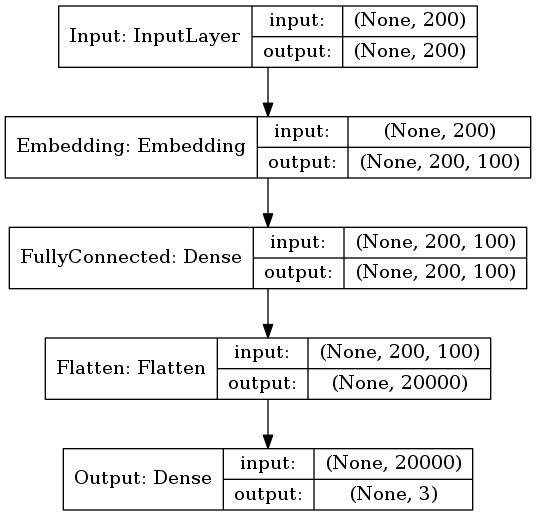

In [14]:
display.display(display.Image(keras.utils.vis_utils.model_to_dot(model, show_shapes=True).create_png()))

### Model Training

In [15]:
history = model.fit(
    [data['train']['text']],
    keras.utils.to_categorical(data['train']['y'],3),
    epochs=10,
    verbose=0,
    callbacks=[
        TQDMNotebookCallback(
            leave_inner=True,
        )
    ],
    validation_data=(
        [data['val']['text']],
        keras.utils.to_categorical(data['val']['y'],3)
    ),
    batch_size=128
)

HBox(children=(IntProgress(value=0, description='Training', max=10), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 0', max=42371), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 1', max=42371), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 2', max=42371), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 3', max=42371), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 4', max=42371), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 5', max=42371), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 6', max=42371), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 7', max=42371), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 8', max=42371), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 9', max=42371), HTML(value='')))

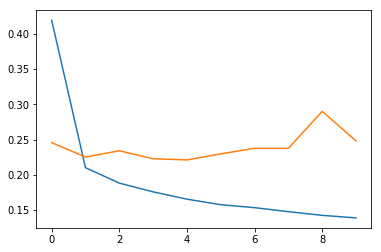

In [16]:
import matplotlib.pyplot as plt

plt.plot(history.epoch,history.history['loss'],history.epoch,history.history['val_loss'])
plt.show()
_=_

### Model Evaluation

Let's use accuracy to evaluate our model:

In [17]:
from sklearn.metrics import accuracy_score


In [18]:
h = model.predict([data['test']['text']])

In [19]:
predict = np.asarray([np.argmax(i) for i in h])
gold = np.asarray(data['test']['y'])
resultf1 = accuracy_score(gold, predict)
print('Accuracy score on {} test samples: {:.6}'.format(
    len(predict), resultf1
))

Accuracy score on 2354 test samples: 0.474936


### Model Improvement


This model is very simple, and it is clearly overfitting. Please make some minimal changes to increase its accuracy without increasing the model complexity.

In [20]:
from keras import regularizers

class ImprovedModel(keras.models.Model):
    
    def __init__(self):
        input_layer = layers.Input(
            shape=(MAX_SEQUENCE_LENGTH,),
            name='Input'
        )
        embedding_layer = layers.Embedding(len(vocabulary) + 1,
                            EMBEDDING_DIM,
                            weights=[embedding_matrix],
                            input_length=MAX_SEQUENCE_LENGTH,
                            name='Embedding')(input_layer)
            
        fc_layer = layers.Dense(
            units=100,
            name='FullyConnected',activation='relu', 
                         kernel_regularizer=regularizers.l2(0.01)
               
        )(embedding_layer)
        #fc_layer  = layers.Dropout(0.2)(fc_layer)
        #fc_layer  = layers.BatchNormalization()(fc_layer)

        fc_layer  = layers.Flatten(name="Flatten")(fc_layer)
        
        predictions = layers.Dense(
            3,
            name='Output'
        )(fc_layer)
        
        super().__init__(inputs=[input_layer], outputs=predictions)
        
    def compile(self):
        return super().compile(
            optimizer=keras.optimizers.Adam(lr=0.0001),
            loss='mse'
        )
    

In [21]:
model2 = ImprovedModel()
model2.compile()

In [22]:
history2 = model2.fit(
    [data['train']['text']],
    keras.utils.to_categorical(data['train']['y'],3),
    epochs=10,
    verbose=0,
    callbacks=[
        TQDMNotebookCallback(
            leave_inner=True,
        )
    ],
    validation_data=(
        [data['val']['text']],
        keras.utils.to_categorical(data['val']['y'],3)
    ),
    batch_size=64
)

HBox(children=(IntProgress(value=0, description='Training', max=10), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 0', max=42371), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 1', max=42371), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 2', max=42371), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 3', max=42371), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 4', max=42371), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 5', max=42371), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 6', max=42371), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 7', max=42371), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 8', max=42371), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 9', max=42371), HTML(value='')))

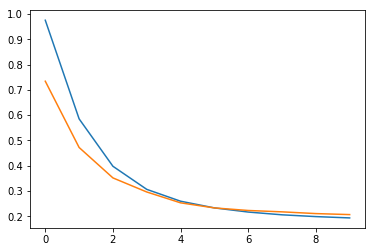

In [23]:
import matplotlib.pyplot as plt

plt.plot(history2.epoch,history2.history['loss'],history2.epoch,history2.history['val_loss'])
plt.show()
_=_

In [24]:
h = model2.predict([data['test']['text']])

In [25]:
predict = np.asarray([np.argmax(i) for i in h])
gold = np.asarray(data['test']['y'])
resultf1 = accuracy_score(gold, predict)
print('Accuracy score on {} test samples: {:.6}'.format(
    len(predict), resultf1
))

Accuracy score on 2354 test samples: 0.541206


### Inference

In [26]:
def infer(texts):
    sequences = []
    for text in texts:
        text = text.split()
        text_sequence = []
        for word in text:
            if word in vocabulary:
                text_sequence.append(vocabulary[word])
        sequences.append(text_sequence)

    padded_seq = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)
    return model.predict([padded_seq])
    

In [27]:
text = ['das ist schlecht',
       'ich finde das echt toll',
       'das ist gut',
       'das ist nicht schlecht',
       'das ist nicht gut',
       'okay vielen dank',]

In [28]:
h_ = infer(text)
for i,t in enumerate(text):
    print('{} {} {}'.format(
            np.argmax(h_[i]),
            h_[i],
            t[:MAX_SEQUENCE_LENGTH],
        ))

2 [ 0.11383253 -0.04374149  0.60586011] das ist schlecht
2 [ 0.0582897  -0.01618246  0.70139676] ich finde das echt toll
2 [ 0.09438464  0.02586528  0.56105644] das ist gut
2 [ 0.2831839   0.03442322  0.38952589] das ist nicht schlecht
2 [ 0.2637361   0.10403002  0.34472218] das ist nicht gut
2 [ 0.16209188 -0.14446892  0.64669871] okay vielen dank


### Model Improvement

Implement a model similar to the one described in [this paper](https://arxiv.org/pdf/1704.06125.pdf), in order to get an even higher accuracy.

Here we implement a bidirectional LSTM model

In [43]:
from keras.regularizers import l2
from keras.models import Sequential

model4 = Sequential()
model4.add(layers.Embedding(len(vocabulary) + 1,
                            EMBEDDING_DIM,
                            weights=[embedding_matrix],
                            input_length=MAX_SEQUENCE_LENGTH,
                            name='Embedding'))
model4.add(layers.SpatialDropout1D(0.5))
model4.add(layers.Bidirectional(layers.LSTM(64, return_sequences=True )))
model4.add(layers.Bidirectional(layers.LSTM(32)))
model4.add(layers.Dropout(0.5))
model4.add(layers.Dense(units=30,activity_regularizer=l2(0.001)))
model4.add(layers.Dropout(0.5))

model4.add(layers.Dense(units=3, activation='softmax',activity_regularizer=l2(0.001)))
model4.compile(loss = 'categorical_crossentropy', optimizer='adam',metrics = ['accuracy'])
print(model4.summary())



_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Embedding (Embedding)        (None, 200, 100)          31098600  
_________________________________________________________________
spatial_dropout1d_4 (Spatial (None, 200, 100)          0         
_________________________________________________________________
bidirectional_6 (Bidirection (None, 200, 128)          84480     
_________________________________________________________________
bidirectional_7 (Bidirection (None, 64)                41216     
_________________________________________________________________
dropout_6 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 30)                1950      
_________________________________________________________________
dropout_7 (Dropout)          (None, 30)                0         
__________

In [ ]:


history = model4.fit( [data['train']['text']],
    keras.utils.to_categorical(data['train']['y'],3), epochs=10, batch_size=128,   
    verbose=0,
    callbacks=[
        TQDMNotebookCallback(
            leave_inner=True,
        )
    ],
    validation_data=(
        [data['val']['text']],
        keras.utils.to_categorical(data['val']['y'],3)
    ))



HBox(children=(IntProgress(value=0, description='Training', max=10), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 0', max=42371), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 1', max=42371), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 2', max=42371), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 3', max=42371), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 4', max=42371), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 5', max=42371), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 6', max=42371), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 7', max=42371), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 8', max=42371), HTML(value='')))

In [ ]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

Here we implement a very simple CNN model on the data. This model has yet to be changed to meet the description of the CNN model in the paper.

In [34]:


class CNNModel(keras.models.Model):
    
    def __init__(self):
        input_layer = layers.Input(
            shape=(MAX_SEQUENCE_LENGTH,),
            name='Input'
        )
        embedding_layer = layers.Embedding(len(vocabulary) + 1,
                            EMBEDDING_DIM,
                            weights=[embedding_matrix],
                            input_length=MAX_SEQUENCE_LENGTH,
                            name='Embedding')(input_layer)
            
        cnn_layer  = layers.Conv1D(activation="relu",
                     filters=100, kernel_size=4, padding="valid")(embedding_layer)
        batchnorm  = layers.BatchNormalization()(cnn_layer)
        dropout  = layers.Dropout(0.2)(batchnorm)
        cnn_layer  = layers.Conv1D(activation="relu",
                     filters=50, kernel_size=3, padding="valid")(dropout)
        batchnorm  = layers.BatchNormalization()(cnn_layer)
        dropout  = layers.Dropout(0.2)(batchnorm)

        fc_layer  = layers.Flatten(name="Flatten")(dropout)
        
        predictions = layers.Dense(
            3,
            name='Output'
        )(fc_layer)
        
        super().__init__(inputs=[input_layer], outputs=predictions)
        
    def compile(self):
        return super().compile(
            optimizer=keras.optimizers.Adam(lr=0.0001),
            loss='mse'
        )
    

In [35]:
model3 = CNNModel()
model3.compile()

In [36]:
history3 = model3.fit(
    [data['train']['text']],
    keras.utils.to_categorical(data['train']['y'],3),
    epochs=15,
    verbose=0,
    callbacks=[
        TQDMNotebookCallback(
            leave_inner=True,
        )
    ],
    validation_data=(
        [data['val']['text']],
        keras.utils.to_categorical(data['val']['y'],3)
    ),
    batch_size=128
)

HBox(children=(IntProgress(value=0, description='Training', max=15), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 0', max=42371), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 1', max=42371), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 2', max=42371), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 3', max=42371), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 4', max=42371), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 5', max=42371), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 6', max=42371), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 7', max=42371), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 8', max=42371), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 9', max=42371), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 10', max=42371), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 11', max=42371), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 12', max=42371), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 13', max=42371), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 14', max=42371), HTML(value='')))

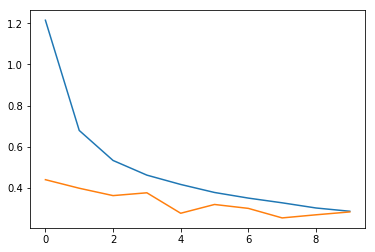

In [33]:
import matplotlib.pyplot as plt

plt.plot(history3.epoch,history3.history['loss'],history3.epoch,history3.history['val_loss'])
plt.show()
_=_

In [37]:
h = model3.predict([data['test']['text']])

In [38]:
predict = np.asarray([np.argmax(i) for i in h])
gold = np.asarray(data['test']['y'])
resultf1 = accuracy_score(gold, predict)
print('Accuracy score on {} test samples: {:.6}'.format(
    len(predict), resultf1
))

Accuracy score on 2354 test samples: 0.480459
